In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Ensemble Learning and Random Forests

* A group of predictors is called an `ensemble`; thus, this technique is called `ensemble learning`, and an ensemble
learning algorithm is called an `ensemble method`.

# Voting Classifiers

* Scikit-Learn provides a VotingClassifier class that’s quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier.

In [2]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

* Let’s look at each fitted classifier’s accuracy on the test set:

In [3]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


* When you call the voting classifier’s predict() method, it performs hard
voting. For example, the voting classifier predicts class 1 for the first instance
of the test set, because two out of three classifiers predict that class:

In [4]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [5]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

* Now let’s look at the performance of the voting classifier on the test set:

In [6]:
voting_clf.score(X_test, y_test)

0.912

* If all classifiers are able to estimate class probabilities (i.e., if they all have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

In [7]:
voting_clf.voting="soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging & Pasting

* When sampling is performed with replacement,⁠ this method is called `bagging⁠` (short for bootstrap aggregating⁠ ). When sampling is performed without replacement, it is called `pasting`.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=42
    
)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

Text(0, 0.5, '')

<Figure size 1152x864 with 0 Axes>

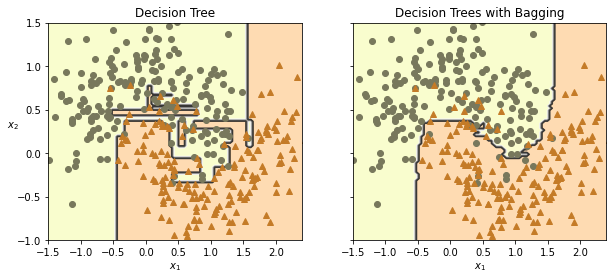

In [9]:
plt.figure(figsize=(16, 12))
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")

## Out of Bag Evaluation

* Out-of-Bag (OOB) means the 37% of training data not used by each model in bagging, and it helps to test the model’s accuracy without needing a separate validation set.

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

* Veryfing

In [11]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

* Since the base estimator has a predict_proba() method, the decision function returns the class probabilities for each training instance.

In [12]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

# Random Forests

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42
)

rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

* `BaggingClassifier` is equivalent to the previous `RandomForestClassifier`:

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(
        max_features="sqrt",
        max_leaf_nodes=16
    ),
    n_estimators=500,
    n_jobs=-1,
    random_state=42
)

## Feature Importance

* Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest.

In [15]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


# Boosting

## Ada Boosting

* When training an AdaBoost classifier, the algorithm first trains a base classifier (such as a decision tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on...

In [16]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(
        max_depth=1
    ),
    n_estimators=30,
    learning_rate=0.5,
    algorithm="SAMME",
    random_state=42
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

## Gradient Boosting

* Gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [17]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:,0]**2 + 0.05 * np.random.rand(100) # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(
    max_depth=2,
    random_state=42
)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [18]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(
    max_depth=2,
    random_state=43
)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [19]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(
    max_depth=2,
    random_state=44
)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

* A new instance simply by adding up the predictions of all the trees:

In [20]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.50199918, 0.08055604, 0.74072131])

Text(0.5, 0, '$x_1$')

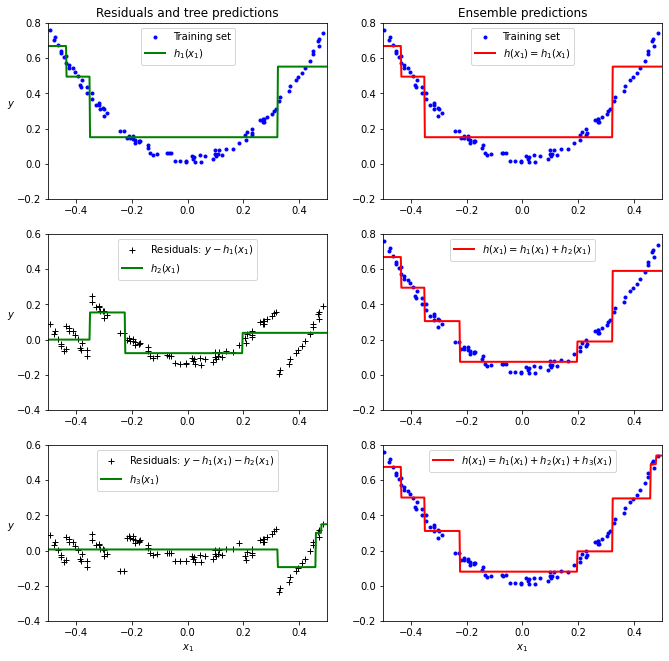

In [21]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

* There is also Scikit-Learn’s GradientBoostingRegressor class to train GBRT ensembles more easily (there’s also a GradientBoostingClassifier class for classification).

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0,
    random_state=42
)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [23]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=500,
    n_iter_no_change=10,
    random_state=42
)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [24]:
gbrt_best.n_estimators_

86

Text(0.5, 0, '$x_1$')

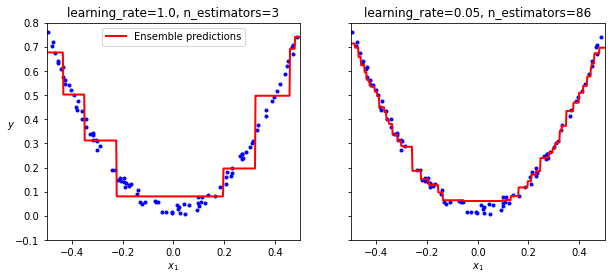

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

* The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.05, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called `shrinkage`.

* To find the optimal number of trees, you could perform cross-validation using GridSearchCV or RandomizedSearchCV, as usual, but there’s a simpler way: if you set the `n_iter_no_change` hyperparameter to an integer value, say 10, then the GradientBoostingRegressor will automatically stop adding more trees during training if it sees that the last 10 trees didn’t help.

## Histogram-Based Gradient Boosting

* HGB is a faster version of Gradient Boosting designed for large datasets. It divides (or "bins") the data into groups, using whole numbers instead of precise values, which makes it faster and saves memory.

In [26]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    return pd.read_csv(Path("C:/Users/MRE/Documents/GitHub/End_to_End_ML_Project/Dataset/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer(
        (
            OrdinalEncoder(),
            ["ocean_proximity"]
        ),
        remainder="passthrough"),
        HistGradientBoostingRegressor(
            categorical_features=[0],
            random_state=42
        )
    )

hgb_reg.fit(housing, housing_labels)

c:\Users\MRE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

# Stacking

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [29]:
stacking_clf.score(X_test, y_test)

0.928

# Exercises

* Load the MNIST dataset (introduced in Chapter 3), and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a random forest classifier, an extra-trees classifier, and an SVM classifier. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [30]:

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

In [31]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [33]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(dual=True, max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [34]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.9626]

* The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

In [35]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [36]:
voting_clf = VotingClassifier(named_estimators)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(dual=True, max_iter=100,
                                        random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [37]:
voting_clf.score(X_valid, y_valid)

0.9751

* The VotingClassifier made a clone of each classifier, and it trained the clones using class indices as the labels, not the original class names. Therefore, to evaluate these clones we need to provide class indices as well. To convert the classes to class indices, we can use a LabelEncoder:

In [38]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

In [39]:
y_valid_encoded = y_valid.astype(np.int64)

In [40]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.9626]

In [41]:
voting_clf.set_params(svm_clf="drop")

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [42]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [43]:
voting_clf.named_estimators_

{'random_forest_clf': RandomForestClassifier(random_state=42),
 'extra_trees_clf': ExtraTreesClassifier(random_state=42),
 'svm_clf': LinearSVC(dual=True, max_iter=100, random_state=42, tol=20),
 'mlp_clf': MLPClassifier(random_state=42)}

In [44]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

In [45]:
voting_clf.score(X_valid, y_valid)

0.9762

In [46]:
voting_clf.voting = "soft"

voting_clf.score(X_valid, y_valid)

0.9697

In [47]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9735

In [48]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

[0.968, 0.9703, 0.9638]

* Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set.

In [49]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [50]:
X_valid_predictions

array([['3', '3', '3', '3'],
       ['8', '8', '8', '8'],
       ['6', '6', '6', '6'],
       ...,
       ['5', '5', '5', '5'],
       ['6', '6', '6', '6'],
       ['8', '8', '8', '8']], dtype=object)

In [51]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [52]:
rnd_forest_blender.oob_score_

0.9732

In [53]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [54]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [55]:
accuracy_score(y_test, y_pred)

0.9691

In [56]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

In [ ]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

In [ ]:
stack_clf.score(X_test, y_test)